In [40]:
# At first lets import modules that we need
import random
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [13]:
# Download the dataset
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [23]:
# Lets write some custom class that will create CNN based model with the given hyperparams

class SimpleCNN(nn.Module):
    def __init__(self, num_blocks=[4, 64, 32], kernel_size=3, activation=nn.ReLU, num_classes=10):
        super().__init__()
        padding = kernel_size // 2
        act = activation

        layers = []
        layers.append(nn.Conv2d(1, num_blocks[0], kernel_size=kernel_size, padding=padding))
        layers.append(act())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        for i in range(len(num_blocks) - 1):
            layers.append(nn.Conv2d(num_blocks[i], num_blocks[i+1], kernel_size=kernel_size, padding=padding))
            layers.append(act())
            if i % 2 == 0:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        layers.append(nn.AdaptiveAvgPool2d((1, 1)))

        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(num_blocks[-1], 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
# Write one function that will handle trainig for given hyperparams 
def train_eval(num_blocks=[3, 64, 32], 
               kernel_size=3, 
               learning_rate=1e-3, 
               activation=nn.ReLU,
               batch_size=32, 
               epochs=5, 
               device='cuda', 
               train_data=train_data, 
               test_data=test_data):
    
    net = SimpleCNN(num_blocks=num_blocks, kernel_size=kernel_size, activation=activation).to(device)

    # Criterion and Optimizer 
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train and test loaders
    train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

    test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = False)

    # Keeping hystory for loss and accuracy

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs + 1):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, preds = outputs.max(1)
            correct += (preds == y).sum().item()
            total += X.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        net.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = net(X)
                loss = loss_function(outputs, y)
                val_loss += loss.item() * X.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == y).sum().item()
                val_total += X.size(0)
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        clear_output(wait=True)
        print(f"Epoch {epoch}/{epochs} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

    return net, history



In [16]:
# Function for plotting the hystory 

def plot_history(hystory):
    """
    Plot training/validation loss and accuracy.
    Accepts dict with keys: 'train_loss','train_acc','val_loss','val_acc'.
    """
    import matplotlib.pyplot as plt
    # tolerate both 'hystory' and common misspelling
    history = hystory

    epochs = range(1, len(history.get('train_loss', [])) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axs[0].plot(epochs, history.get('train_loss', []), marker='o', label='train_loss')
    axs[0].plot(epochs, history.get('val_loss', []), marker='o', label='val_loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    axs[0].legend()

    # Accuracy
    axs[1].plot(epochs, history.get('train_acc', []), marker='o', label='train_acc')
    axs[1].plot(epochs, history.get('val_acc', []), marker='o', label='val_acc')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [27]:
# Create model and try to train it 
HYPER_PAR_1 = {
    'num_blocks':[4, 32, 64, 32],
    'kernel_size':3, 
    'activation':nn.ReLU,
    'epochs':20,
    'batch_size':100
}

net1, hystory = train_eval(**HYPER_PAR_1)

Epoch 20/20 — train_loss: 0.0318, train_acc: 0.9897, val_loss: 0.0368, val_acc: 0.9888


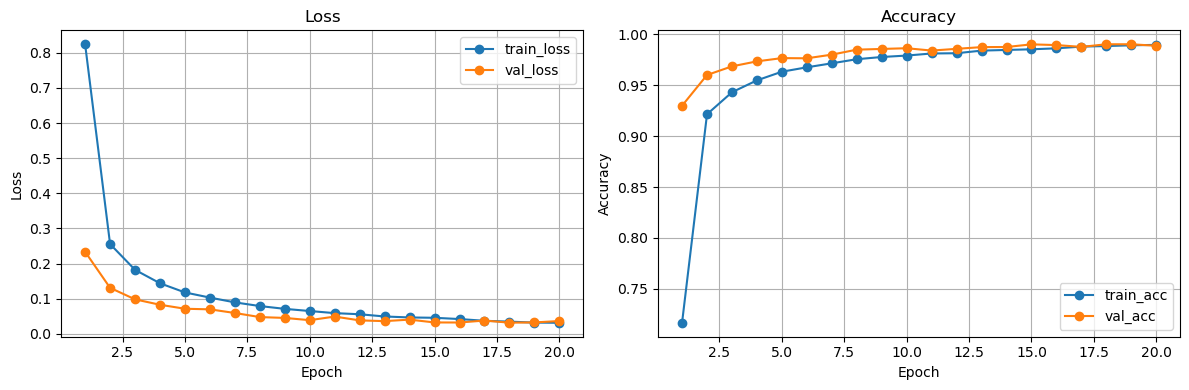

In [28]:
plot_history(hystory)

In [ ]:
# Second try with other blocks
HYPER_PAR_2 = {
    'num_blocks':[8, 32, 64, 32],
    'kernel_size':3, 
    'activation':nn.ReLU,
    'epochs':20,
    'batch_size':100
}

net2, hystory2 = train_eval(**HYPER_PAR_1)

Epoch 20/20 — train_loss: 0.0355, train_acc: 0.9887, val_loss: 0.0380, val_acc: 0.9886


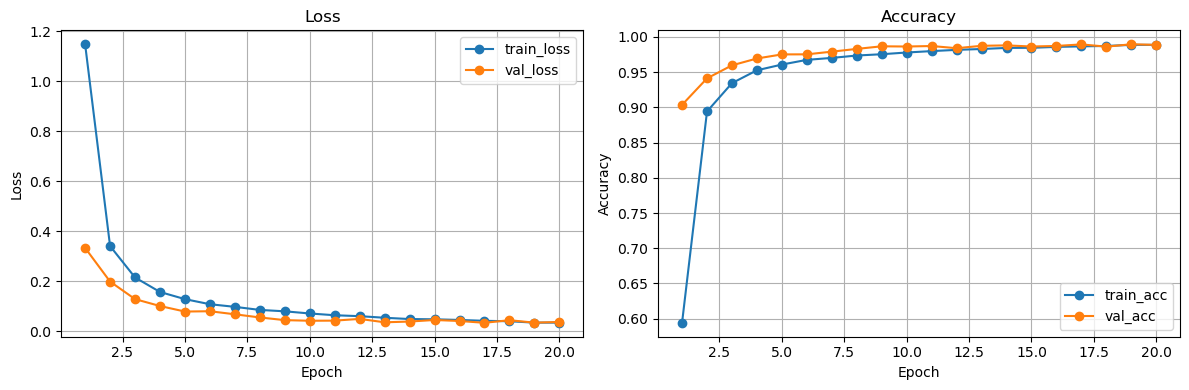

In [30]:
plot_history(hystory2)

In [37]:
# Third model with lower learning rate
HYPER_PAR_3 = {
    'num_blocks':[4, 32, 64, 32],
    'kernel_size':3, 
    'activation':nn.ReLU,
    'epochs':20,
    'batch_size':100,
    'learning_rate':1e-4,
    'device':'cuda'
}

net3, hystory3 = train_eval(**HYPER_PAR_1)

Epoch 20/20 — train_loss: 0.0371, train_acc: 0.9886, val_loss: 0.0270, val_acc: 0.9916


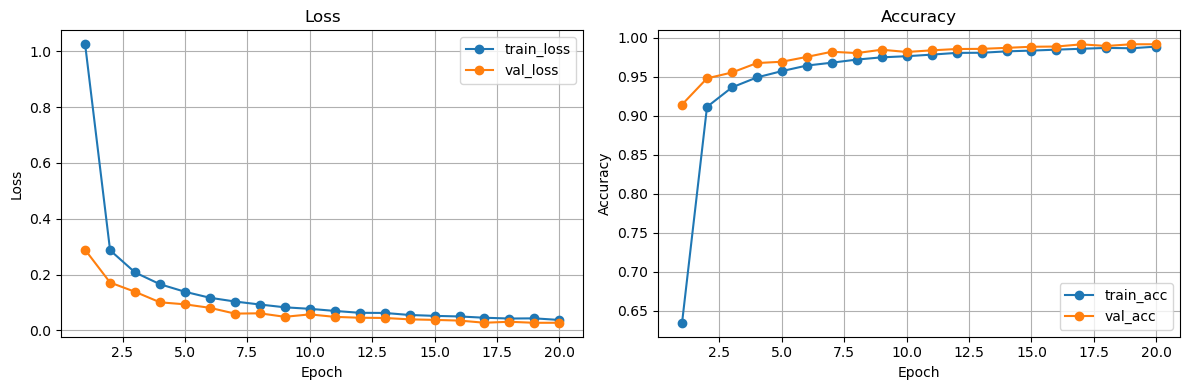

In [38]:
plot_history(hystory3)

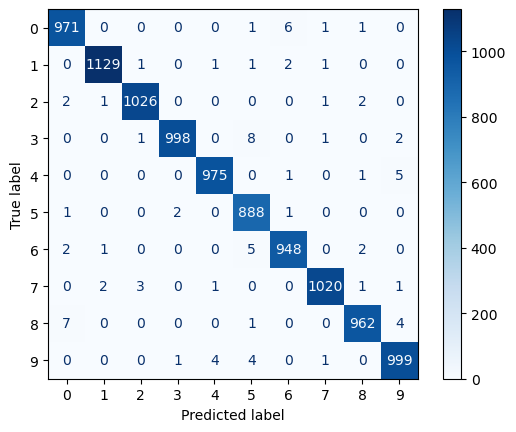

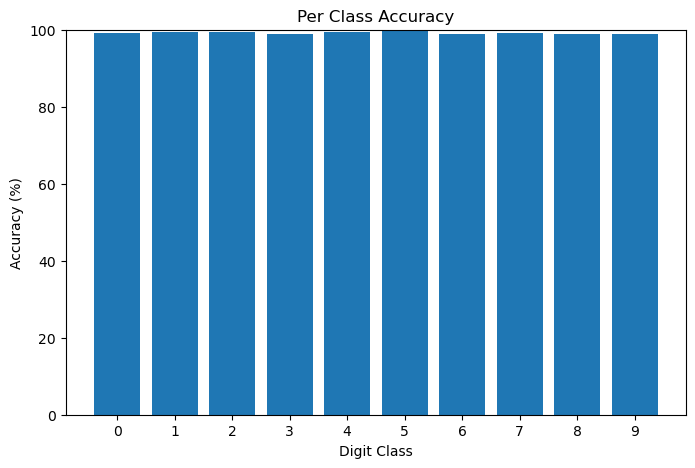

In [39]:
# As The third model was the best lets check the confusion matrix 

all_preds = []
all_labels = []

net3.eval()
with torch.no_grad():
    for data, target in DataLoader(test_data, batch_size=1000):
        data, target = data.to(HYPER_PAR_3['device']), target.to(HYPER_PAR_3['device'])
        output = net3(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)

# Lets see plot per class accuracy 
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,5))
plt.bar(range(10), class_accuracy*100)
plt.xlabel('Digit Class')
plt.ylabel('Accuracy (%)')
plt.title('Per Class Accuracy')
plt.xticks(range(10))
plt.ylim(0, 100)
plt.show()


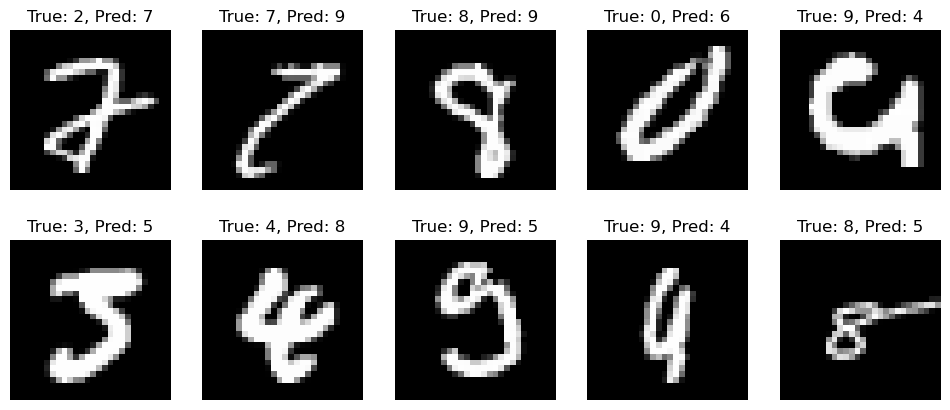

In [ ]:
# Plot some misclassified samples

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
wrong_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]
sampled_wrong_indices = random.sample(wrong_indices, 10)
net3.eval()
for ax, idx in zip(axes.flatten(), sampled_wrong_indices):
    flat_image, label = test_data[idx]                           
    input_tensor = flat_image.unsqueeze(0).to(HYPER_PAR_3['device'])  
    with torch.no_grad():
        output = net3(input_tensor)
        pred = output.argmax(dim=1).item()                       
    ax.imshow(flat_image.view(28, 28).cpu(), cmap='gray')         
    ax.set_title(f'True: {int(label)}, Pred: {pred}')
    ax.axis('off')
plt.show()

In [ ]:
# Also it is interesting to see hot do our kernels look

def plot_kernels(model, layer_index=0, max_kernels=64, ncols=8, cmap='gray', normalize=True):

    import math

    convs = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
    if not convs:
        raise ValueError("No Conv2d layers found in model.")
    if layer_index < 0 or layer_index >= len(convs):
        raise IndexError(f"layer_index out of range (0..{len(convs)-1}).")

    conv = convs[layer_index]
    W = conv.weight.detach().cpu()  # shape: (out_ch, in_ch, k, k)

    out_ch, in_ch, kH, kW = W.shape
    n_show = min(out_ch, max_kernels)
    kernels = W[:n_show]  # (n_show, in_ch, kH, kW)

    # reduce multi-channel kernels to single 2D image per filter by mean over input channels
    if in_ch > 1:
        kernels = kernels.mean(dim=1)  # (n_show, kH, kW)
    else:
        kernels = kernels.squeeze(1)   # (n_show, kH, kW)

    # optional normalization per kernel for better contrast
    kern_imgs = []
    for i in range(n_show):
        img = kernels[i].numpy()
        if normalize:
            mn, mx = img.min(), img.max()
            if mx - mn > 1e-6:
                img = (img - mn) / (mx - mn)
            else:
                img = img - mn
        kern_imgs.append(img)

    nrows = math.ceil(n_show / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5))
    axes = axes.flatten() if n_show > 1 else [axes]

    for ax in axes:
        ax.axis('off')

    for i, img in enumerate(kern_imgs):
        ax = axes[i]
        ax.imshow(img, cmap=cmap, interpolation='nearest')
        ax.set_title(f'F{i}', fontsize=8)
        ax.axis('off')

    plt.suptitle(f'Conv layer {layer_index} kernels (out_ch={out_ch}, in_ch={in_ch}, k={kH}x{kW})', fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

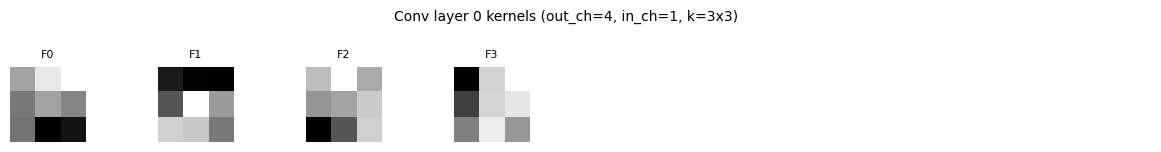

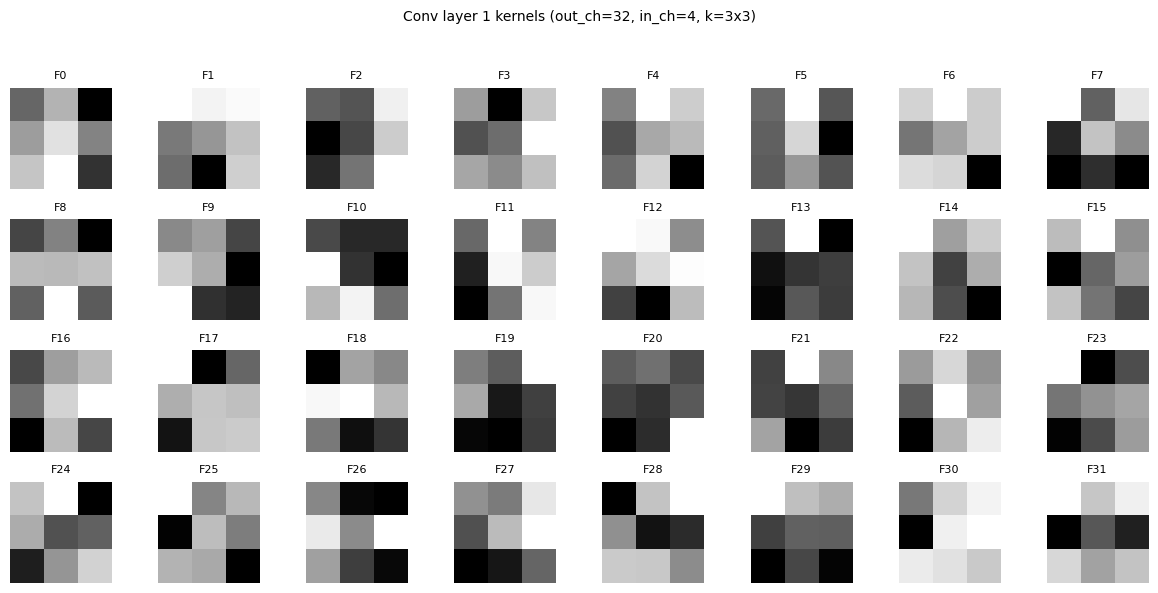

In [45]:
plot_kernels(net3)
plot_kernels(net3, 1)
